## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [63]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import timm

We always check that we are running on a GPU

In [64]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [65]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='./hotdog_nothotdog/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
size = 224
#train_transform = transforms.Compose([transforms.Resize((size, size)),
#                                    transforms.ToTensor()])
#test_transform = transforms.Compose([transforms.Resize((size, size)),
#                                    transforms.ToTensor()])

#""" #optional data augmentation
train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
#"""


batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Now create a model and train it!


In [67]:
#2047 pics of hotdogs & not hotdogs in train set
#1862 pics of hotdog & not hotdogs in test set
#-> balanced sets, no weight for sampler

#EfficientNet B0 model
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
model = model.to(torch.device("cuda"))

#oprtimizer (might change)
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4) #maybe more
#loss function (might change -> nn.LogSoftmax or nn.CrossEntropyLoss or ?)
loss_fn = nn.BCEWithLogitsLoss()
#scheduler for adaptive learning rate, if the gradient is stuck
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.2)



In [68]:
#logs accuracy&loss
output_dict = {'training_loss': [], 'test_loss': [], 'accuracy': [], 'f1': []}

#training loop
epochs = 20
device = torch.device("cuda")

for epoch in tqdm(range(epochs), unit='epoch'):
    model.train()
    train_loss = 0.0

    for _, (data, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        #to device
        data = data.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        #zero gradient
        optimizer.zero_grad()
        #forward pass
        outputs = model(data)
        #compute loss
        loss = loss_fn(outputs, labels)
        #backward pass
        loss.backward()
        #update weights
        optimizer.step()

        #add loss to plot
        train_loss += loss.item()

    avg_training_loss = train_loss / len(train_loader)

    #model validation / test accuracy
    model.eval()
    test_loss = 0.0
    predicted_val = []
    true_val = []

    #same with test set
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(data)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()

            #squeeze btw 0 and 1
            probs = torch.sigmoid(outputs).cpu().numpy()
            #add to list if predicted ie. if probs > 0.5
            predicted_val.extend((probs > 0.5).astype(int))
            true_val.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    accuracy = accuracy_score(true_val, predicted_val)
    f1 = f1_score(true_val, predicted_val)

    output_dict['training_loss'].append(avg_training_loss)
    output_dict['test_loss'].append(avg_test_loss)
    output_dict['accuracy'].append(accuracy)
    output_dict['f1'].append(f1)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_training_loss:.4f} | Val Loss: {avg_test_loss:.4f} | Acc: {accuracy:.4f} | F1: {f1:.4f}")
    #upudating learning rate
    scheduler.step(avg_test_loss)

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.4888 | Val Loss: 0.9558 | Acc: 0.8636 | F1: 0.8662


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.4880 | Val Loss: 0.8383 | Acc: 0.8786 | F1: 0.8798


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.2817 | Val Loss: 0.7155 | Acc: 0.8818 | F1: 0.8880


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.2087 | Val Loss: 0.7306 | Acc: 0.8770 | F1: 0.8817


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.1324 | Val Loss: 0.6992 | Acc: 0.8840 | F1: 0.8879


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.0976 | Val Loss: 0.7015 | Acc: 0.8926 | F1: 0.8967


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.0979 | Val Loss: 0.7148 | Acc: 0.8963 | F1: 0.9008


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.0587 | Val Loss: 0.7051 | Acc: 0.8937 | F1: 0.8976


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.0398 | Val Loss: 0.7076 | Acc: 0.8947 | F1: 0.8983


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0439 | Val Loss: 0.6934 | Acc: 0.8969 | F1: 0.9010


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0376 | Val Loss: 0.6969 | Acc: 0.8985 | F1: 0.9019


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0251 | Val Loss: 0.6819 | Acc: 0.8996 | F1: 0.9032


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0437 | Val Loss: 0.6815 | Acc: 0.8963 | F1: 0.9001


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0198 | Val Loss: 0.6878 | Acc: 0.8985 | F1: 0.9017


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0330 | Val Loss: 0.7021 | Acc: 0.8996 | F1: 0.9023


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0402 | Val Loss: 0.6872 | Acc: 0.8996 | F1: 0.9026


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0188 | Val Loss: 0.6944 | Acc: 0.8985 | F1: 0.9037


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0293 | Val Loss: 0.6799 | Acc: 0.8990 | F1: 0.9022


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0318 | Val Loss: 0.6891 | Acc: 0.8985 | F1: 0.9021


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0291 | Val Loss: 0.6851 | Acc: 0.9006 | F1: 0.9040


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


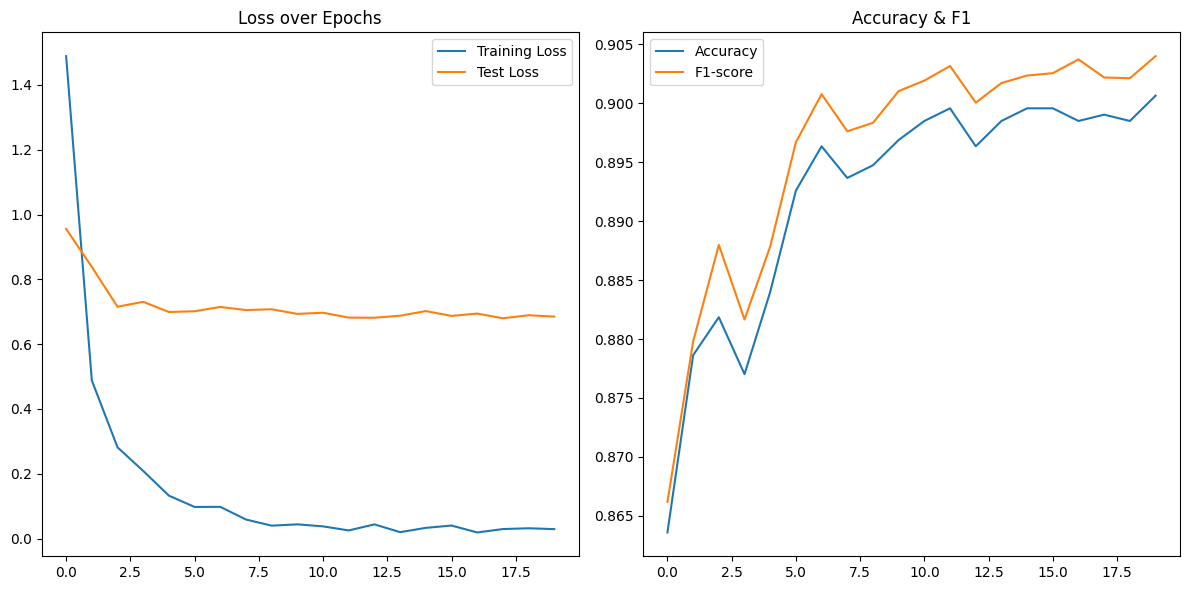

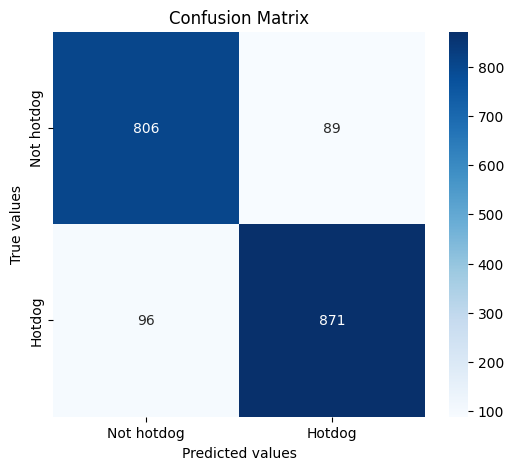

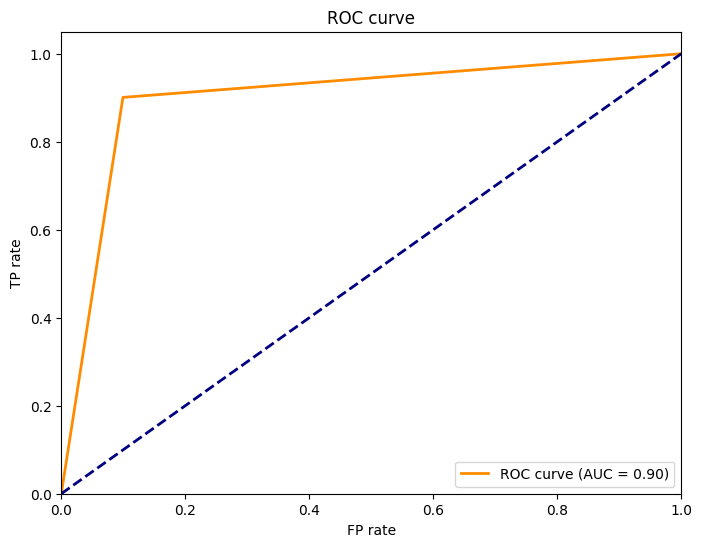

In [69]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

#metrics and plots
def plot_metrics(output_dict, true, preds):

    #losses and accuracies
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(output_dict['training_loss'], label='Training Loss')
    plt.plot(output_dict['test_loss'], label='Test Loss')
    plt.legend()
    plt.title("Loss over Epochs")

    plt.subplot(1, 2, 2)

    plt.plot(output_dict['accuracy'], label='Accuracy')
    plt.plot(output_dict['f1'], label='F1-score')
    plt.legend()
    plt.title("Accuracy & F1")
    plt.tight_layout()

    plt.show()

    #confusion matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["Not hotdog", "Hotdog"], yticklabels=["Not hotdog", "Hotdog"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted values")
    plt.ylabel("True values")

    plt.show()

    #ROC curve & AUC
    fpr, tpr, _ = roc_curve(true, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FP rate')
    plt.ylabel('TP rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()


model.eval()
preds = []
true = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds.extend((probs > 0.5).astype(int))
        true.extend(labels.cpu().numpy())

#call
plot_metrics(output_dict, true_val, predicted_val)
